<a href="https://colab.research.google.com/github/NedKost/MS-AAI-500-Team-Project/blob/Anova-Branch/Collisions_timeslice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

with open('/content/Motor_Vehicle_Collisions_Crashes.csv', 'r') as f:
    lines = f.readlines()
    for i in range(656688, 656694):  # Checking a few lines around the problematic row
        print(i, lines[i-1])  # Adjusting for 0-indexing


656688 04/25/2018,8:39,,,40.63529,-73.958206,"(40.63529, -73.958206)",OCEAN AVENUE                    ,,,1,0,0,0,0,0,1,0,Driver Inattention/Distraction,Unspecified,,,,3887903,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,,,

656689 05/08/2018,16:13,,,40.61384,-73.981445,"(40.61384, -73.981445)",65 STREET                       ,,,0,0,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,,,,3896211,Box Truck,Station Wagon/Sport Utility Vehicle,,,

656690 04/29/2018,14:45,BROOKLYN,11208,40.668613,-73.86857,"(40.668613, -73.86857)",,,2602      LINDEN BOULEVARD              ,0,0,0,0,0,0,0,0,Unspecified,,,,,3891070,Station Wagon/Sport Utility Vehicle,,,,

656691 05/14/2018,15:00,,,40.617573,-74.15293,"(40.617573, -74.15293)",,,5         DEPPE PLACE                   ,0,0,0,0,0,0,0,0,Following Too Closely,Following Too Closely,Unspecified,,,3900833,Sedan,Station Wagon/Sport Utility Vehicle,,,

656692 05/06/2018,11:30,BRONX,10458,40.856358,-73.88591,"(40.856358, -73.

In [ ]:
df = pd.read_csv('/content/Motor_Vehicle_Collisions_Crashes.csv', skiprows=[656692])


In [ ]:
with open('/content/Motor_Vehicle_Collisions_Crashes.csv', 'r') as f:
    lines = f.readlines()

# Excluding problematic line
cleaned_lines = [line for idx, line in enumerate(lines) if idx != 656691]

# Converting cleaned lines into a DataFrame
from io import StringIO
data = StringIO('\n'.join(cleaned_lines))
df = pd.read_csv(data)


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716610 entries, 0 to 716609
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH DATE                     716610 non-null  object 
 1   CRASH TIME                     716610 non-null  object 
 2   BOROUGH                        465568 non-null  object 
 3   ZIP CODE                       465457 non-null  float64
 4   LATITUDE                       661053 non-null  float64
 5   LONGITUDE                      661053 non-null  float64
 6   LOCATION                       661053 non-null  object 
 7   ON STREET NAME                 536006 non-null  object 
 8   CROSS STREET NAME              345998 non-null  object 
 9   OFF STREET NAME                179915 non-null  object 
 10  NUMBER OF PERSONS INJURED      716604 non-null  float64
 11  NUMBER OF PERSONS KILLED       716597 non-null  float64
 12  NUMBER OF PEDESTRIANS INJURED 

In [ ]:
df['YEAR'] = df['CRASH DATE'].apply(lambda x: int(x.split('/')[2]))
df = df[df['YEAR'] > 2018]


In [ ]:
causation_mapping_df = pd.read_csv('causation_factor_mapping_file.csv')

def map_causation(cause, mapping_df):
    """Return the category corresponding to a causation factor."""

    if pd.isna(cause):
        return 'Unknown'

    return mapping_df[mapping_df['Causation Factor'] == cause]['Category'].iloc[0]

# Apply the mapping function to the 'CONTRIBUTING FACTOR VEHICLE 1' column
df['CAUSE CATEGORY'] = df['CONTRIBUTING FACTOR VEHICLE 1'].apply(lambda x: map_causation(x, causation_mapping_df))


 Convert 'CRASH DATE' and 'CRASH TIME' to Datetime Format

In [ ]:
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME']).dt.time


For easier analysis, extracting specific time-based features


In [ ]:
# Extracting Month, Day, Day of the Week, and Hour
df['MONTH'] = df['CRASH DATE'].dt.month
df['DAY'] = df['CRASH DATE'].dt.day
df['DAY_OF_WEEK'] = df['CRASH DATE'].dt.dayofweek  # Returns 0 for Monday and 6 for Sunday
df['HOUR'] = df['CRASH DATE'].dt.hour


Handling missing values (if any)

In [ ]:
# Check for missing values in 'CRASH DATE' and 'CRASH TIME'
missing_dates = df['CRASH DATE'].isna().sum()
missing_times = df['CRASH TIME'].isna().sum()

print(f"Missing Dates: {missing_dates}")
print(f"Missing Times: {missing_times}")


Missing Dates: 0
Missing Times: 0


Outlier Detection

In [ ]:
print("Earliest Crash Date:", df['CRASH DATE'].min())
print("Latest Crash Date:", df['CRASH DATE'].max())


Earliest Crash Date: 2019-01-01 00:00:00
Latest Crash Date: 2023-07-23 00:00:00


Depending on the geographic region, accidents may have some seasonality (e.g., more accidents during winter months due to snow). Adding a 'SEASON' column

In [ ]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['SEASON'] = df['MONTH'].apply(get_season)


Time of day, as in, classify 'CRASH TIME' into periods of the day

In [ ]:
from datetime import time

def get_time_period(t):
    if t < time(6, 0):
        return 'Night'
    elif t < time(12, 0):
        return 'Morning'
    elif t < time(17, 0):
        return 'Afternoon'
    elif t < time(20, 0):
        return 'Evening'
    else:
        return 'Night'

df['TIME_PERIOD'] = df['CRASH TIME'].apply(get_time_period)



In [ ]:
#checking for duplicates
duplicates = df.duplicated().sum()
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Dropped {duplicates} duplicates.")
else:
    print("No duplicates found.")


No duplicates found.


Now making sure the derived columns have been correctly created and populated:

In [ ]:
print(df[['MONTH', 'DAY', 'DAY_OF_WEEK', 'HOUR', 'SEASON', 'TIME_PERIOD']].head())


   MONTH  DAY  DAY_OF_WEEK  HOUR  SEASON TIME_PERIOD
0      9   11            5     0  Autumn       Night
1      3   26            5     0  Spring     Morning
2      6   29            2     0  Summer     Morning
3      9   11            5     0  Autumn     Morning
4     12   14            1     0  Winter     Morning


In [ ]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 504301 entries, 0 to 705309
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   CRASH DATE                     504301 non-null  datetime64[ns]
 1   CRASH TIME                     504301 non-null  object        
 2   BOROUGH                        328866 non-null  object        
 3   ZIP CODE                       328790 non-null  float64       
 4   LATITUDE                       462893 non-null  float64       
 5   LONGITUDE                      462893 non-null  float64       
 6   LOCATION                       462893 non-null  object        
 7   ON STREET NAME                 374838 non-null  object        
 8   CROSS STREET NAME              240735 non-null  object        
 9   OFF STREET NAME                129433 non-null  object        
 10  NUMBER OF PERSONS INJURED      504300 non-null  float64       
 11  

EXPLORATORY ANALYSIS

Distribution of accidents throughout various time features.



In [ ]:
print(df['YEAR'].value_counts().sort_index())
print(df['MONTH'].value_counts().sort_index())
print(df['DAY'].value_counts().sort_index())
print(df['HOUR'].value_counts().sort_index())
print(df['DAY_OF_WEEK'].value_counts().sort_index())
print(df['SEASON'].value_counts())
print(df['TIME_PERIOD'].value_counts())


2019    211485
2020    112908
2021    110526
2022     69315
2023        67
Name: YEAR, dtype: int64
1     46890
2     44117
3     45941
4     38244
5     45484
6     47216
7     46558
8     45218
9     37670
10    37554
11    35385
12    34024
Name: MONTH, dtype: int64
1     16663
2     16561
3     16965
4     16746
5     16701
6     16814
7     16814
8     16742
9     16290
10    16617
11    16756
12    17108
13    16868
14    16731
15    17059
16    16638
17    16294
18    17222
19    16468
20    16422
21    16469
22    16448
23    16559
24    16398
25    15955
26    16409
27    16016
28    15930
29    15142
30    14812
31     9684
Name: DAY, dtype: int64
0    504301
Name: HOUR, dtype: int64
0    71510
1    73384
2    72851
3    74528
4    80156
5    69753
6    62119
Name: DAY_OF_WEEK, dtype: int64
Summer    138992
Spring    129669
Winter    125031
Autumn    110609
Name: SEASON, dtype: int64
Afternoon    153731
Night        133753
Morning      128343
Evening       88474
Name: TIME_PE

Visualizing for better understanding

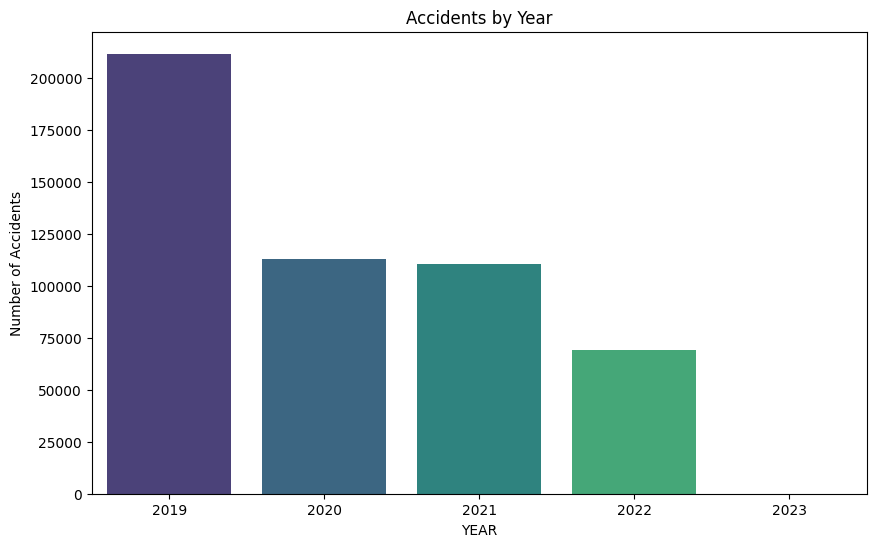

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Yearly trends
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='YEAR', palette="viridis")
plt.title('Accidents by Year')
plt.ylabel('Number of Accidents')
plt.show()


Monthly trends

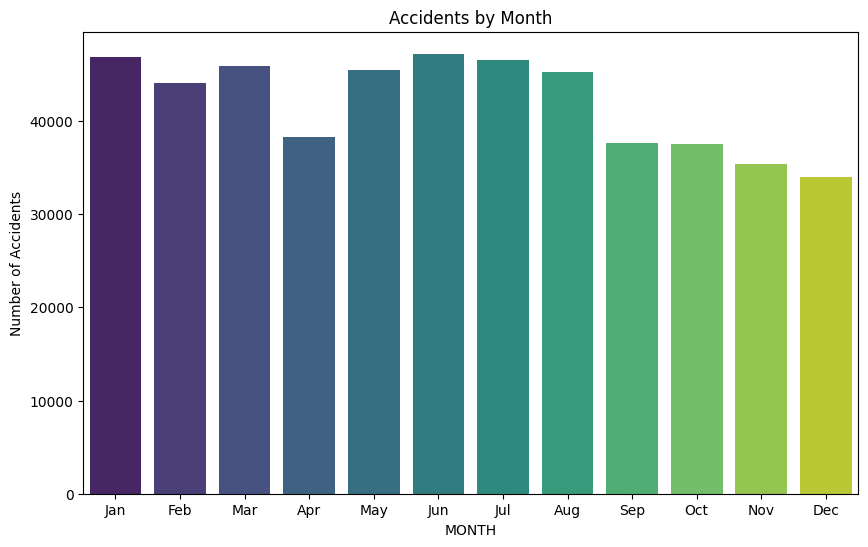

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='MONTH', palette="viridis")
plt.title('Accidents by Month')
plt.ylabel('Number of Accidents')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


Hourly trends

In [ ]:
df['HOUR'] = df['CRASH TIME'].apply(lambda x: x.hour)
print(df['HOUR'].value_counts().sort_index())


0     20251
1     10151
2      7879
3      7008
4      7502
5      8136
6     12414
7     16722
8     26159
9     24350
10    23559
11    25139
12    26942
13    28300
14    32522
15    31836
16    34131
17    33639
18    30014
19    24821
20    21082
21    18770
22    17538
23    15436
Name: HOUR, dtype: int64


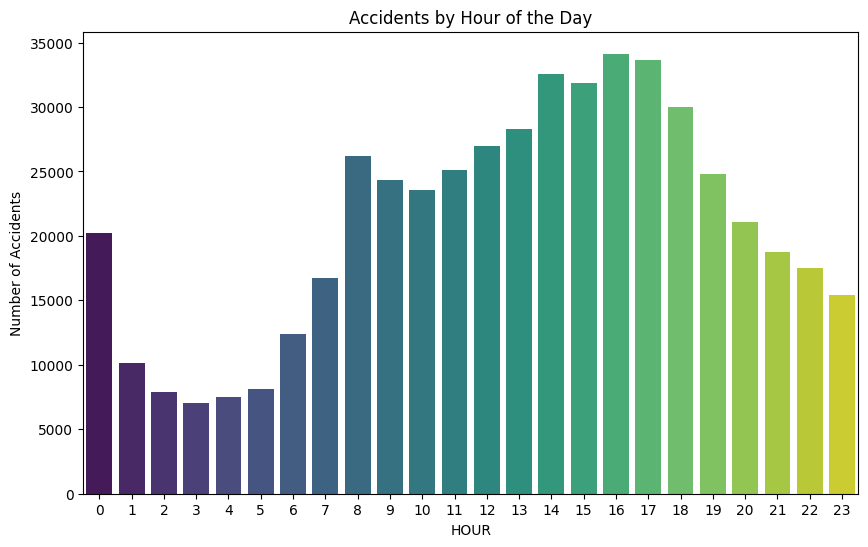

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='HOUR', palette="viridis")
plt.title('Accidents by Hour of the Day')
plt.ylabel('Number of Accidents')
plt.show()


Day of week trend

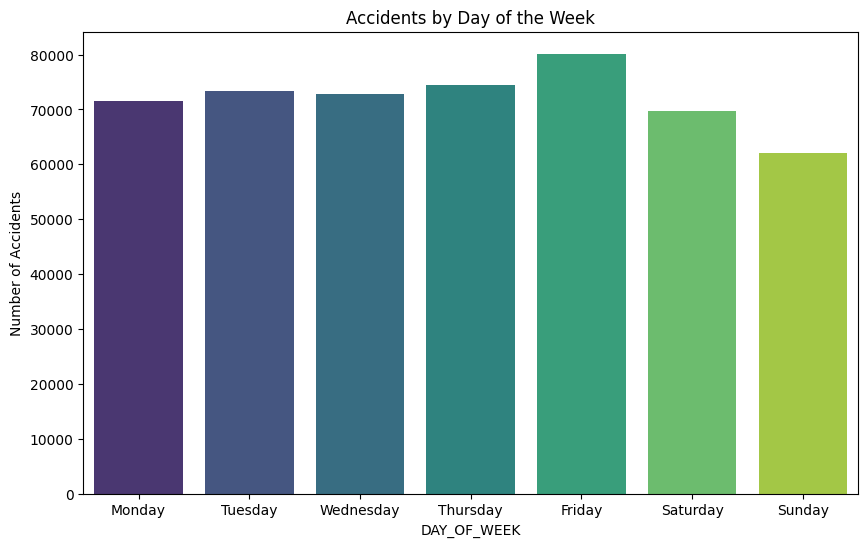

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='DAY_OF_WEEK', palette="viridis")
plt.title('Accidents by Day of the Week')
plt.ylabel('Number of Accidents')
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()


By time period

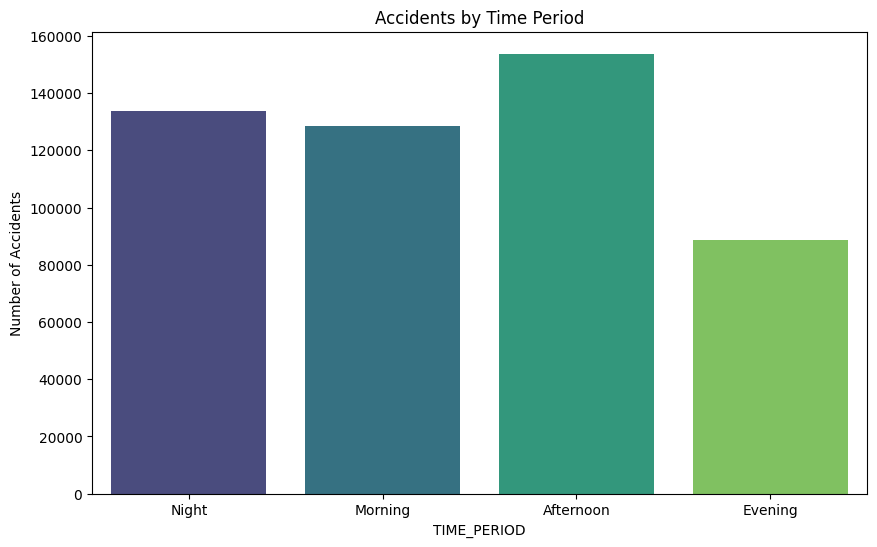

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='TIME_PERIOD', palette="viridis", order=['Night', 'Morning', 'Afternoon', 'Evening'])
plt.title('Accidents by Time Period')
plt.ylabel('Number of Accidents')
plt.show()


Seasons: generic, we will go more in depth with seasons later.

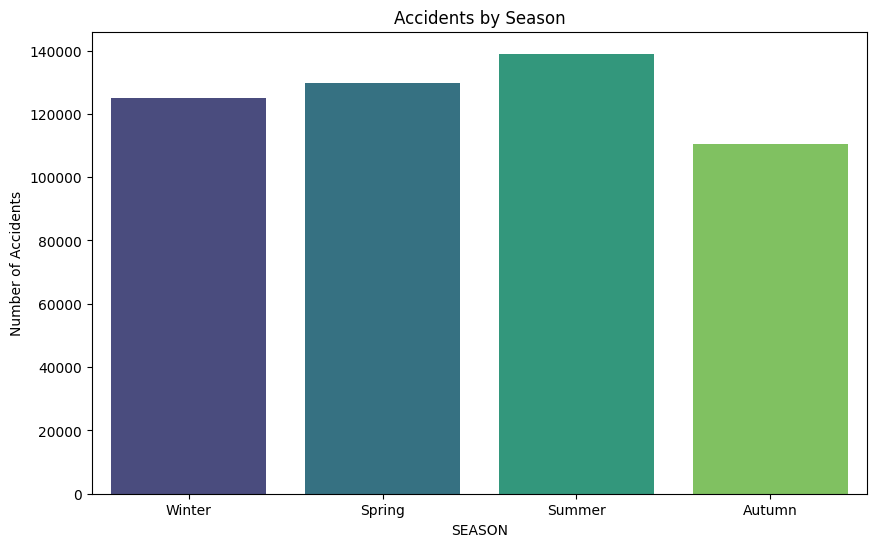

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='SEASON', palette="viridis", order=['Winter', 'Spring', 'Summer', 'Autumn'])
plt.title('Accidents by Season')
plt.ylabel('Number of Accidents')
plt.show()


COMPARATIVE ANALYSIS

Accidents by borough and time

Yealy trend

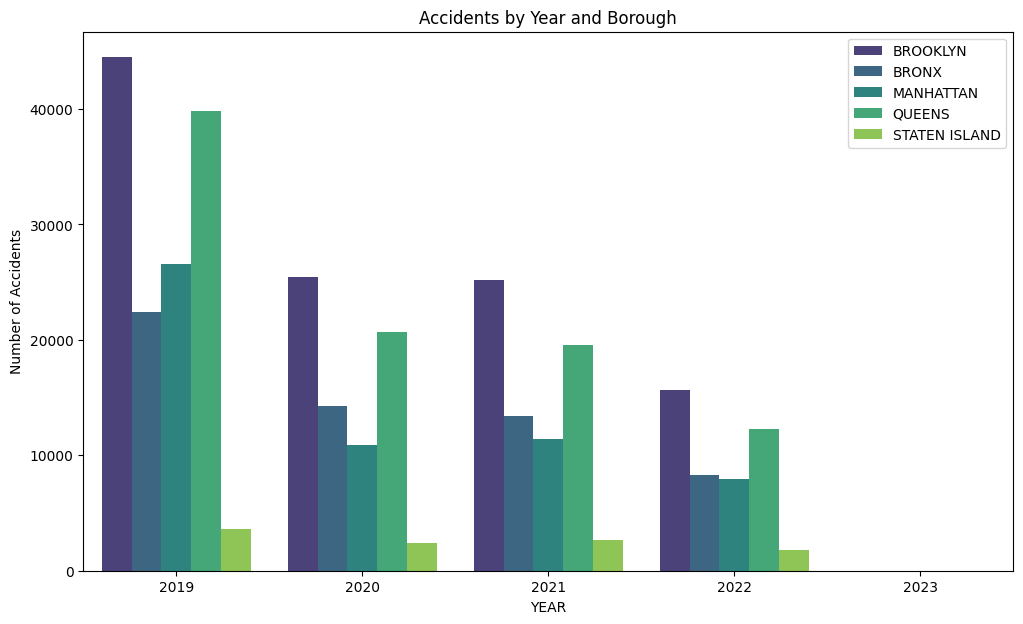

In [ ]:
plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='YEAR', hue='BOROUGH', palette="viridis")
plt.title('Accidents by Year and Borough')
plt.ylabel('Number of Accidents')
plt.legend(loc='upper right')
plt.show()


Monthly trend (by borough)

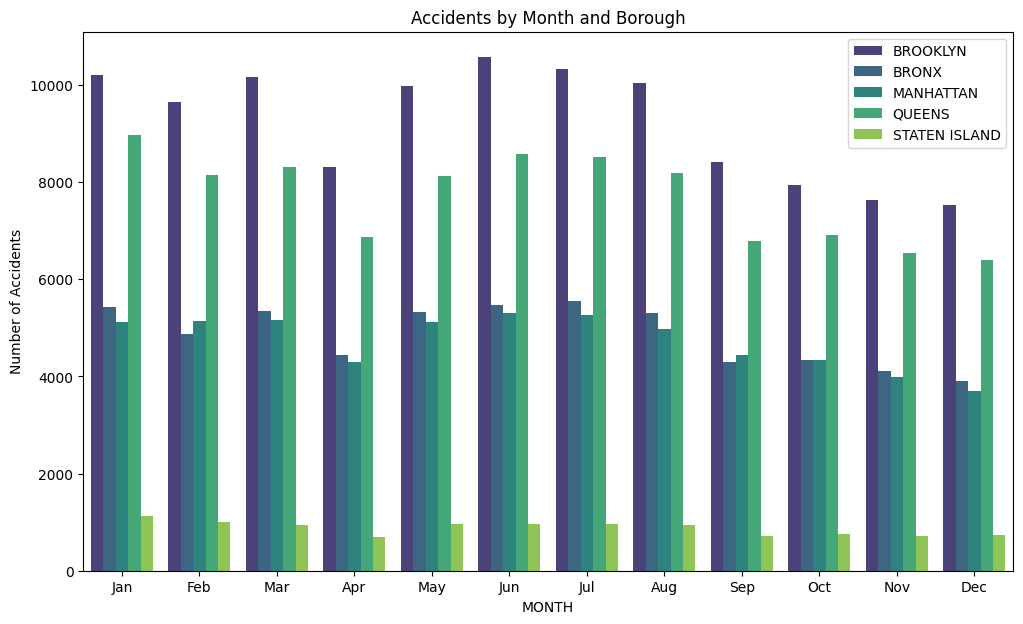

In [ ]:
plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='MONTH', hue='BOROUGH', palette="viridis")
plt.title('Accidents by Month and Borough')
plt.ylabel('Number of Accidents')
plt.legend(loc='upper right')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


Hourly trend

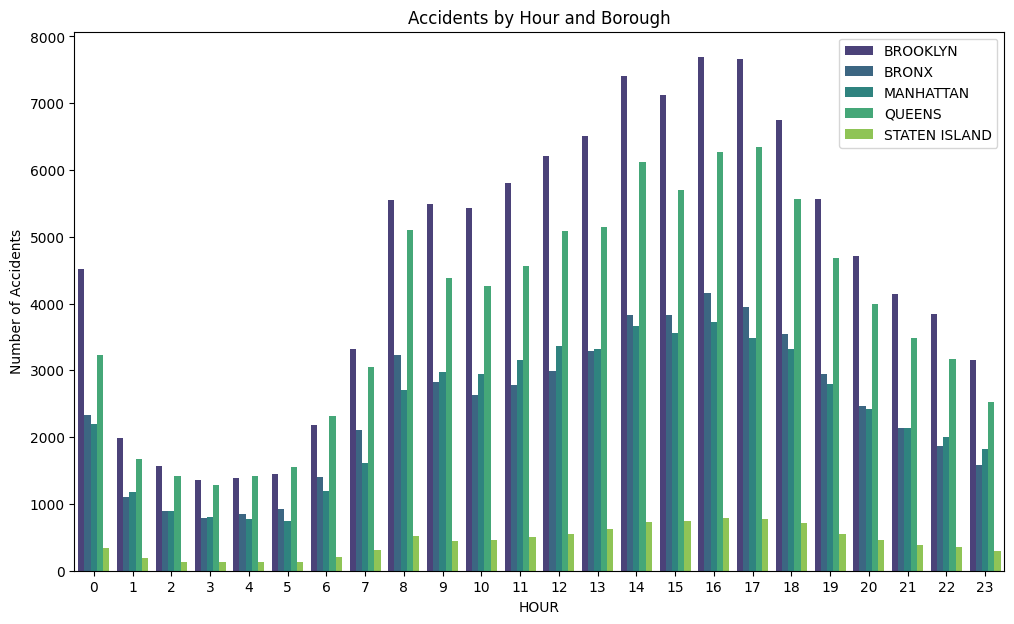

In [ ]:
plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='HOUR', hue='BOROUGH', palette="viridis")
plt.title('Accidents by Hour and Borough')
plt.ylabel('Number of Accidents')
plt.legend(loc='upper right')
plt.show()


ACCIDENTS BY SEVERITY AND TIME

Yearly trend

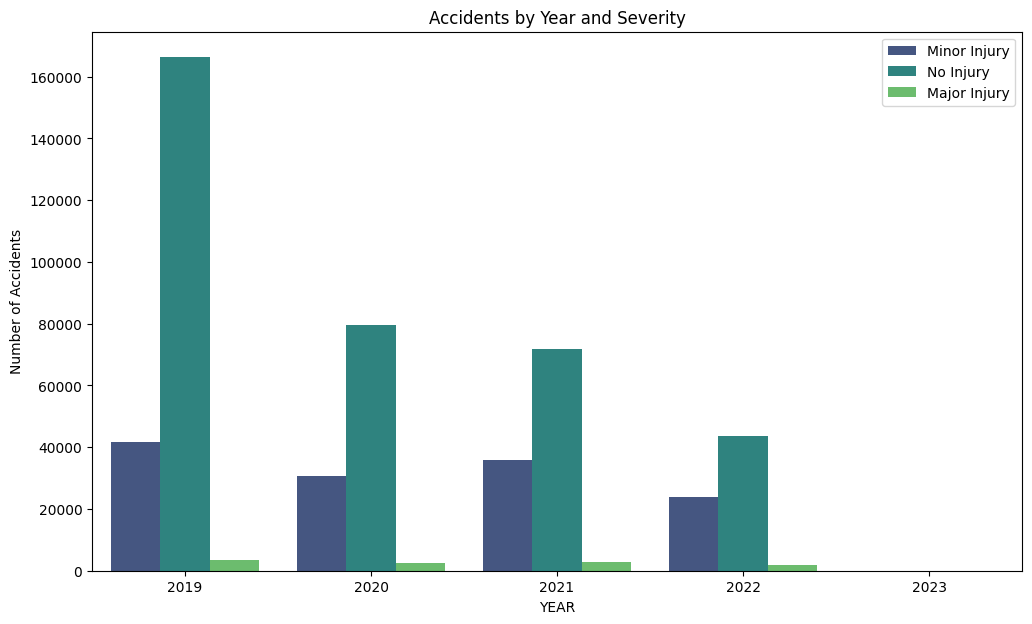

In [ ]:
df['SEVERITY'] = df['NUMBER OF PERSONS INJURED'].apply(lambda x: 'No Injury' if x == 0 else ('Minor Injury' if x < 3 else 'Major Injury'))
plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='YEAR', hue='SEVERITY', palette="viridis")
plt.title('Accidents by Year and Severity')
plt.ylabel('Number of Accidents')
plt.legend(loc='upper right')
plt.show()


Hourly by severity

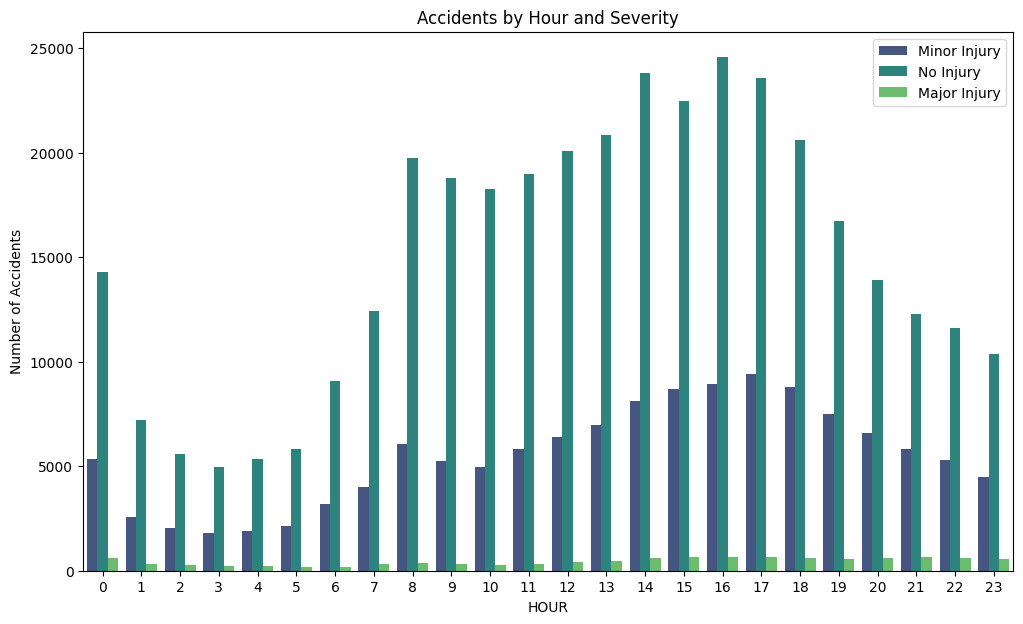

In [ ]:
plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='HOUR', hue='SEVERITY', palette="viridis")
plt.title('Accidents by Hour and Severity')
plt.ylabel('Number of Accidents')
plt.legend(loc='upper right')
plt.show()


ACCIDENTS BY CAUSES AND TIME

In [ ]:
df = df[df['CONTRIBUTING FACTOR VEHICLE 1'] != 'Unspecified']


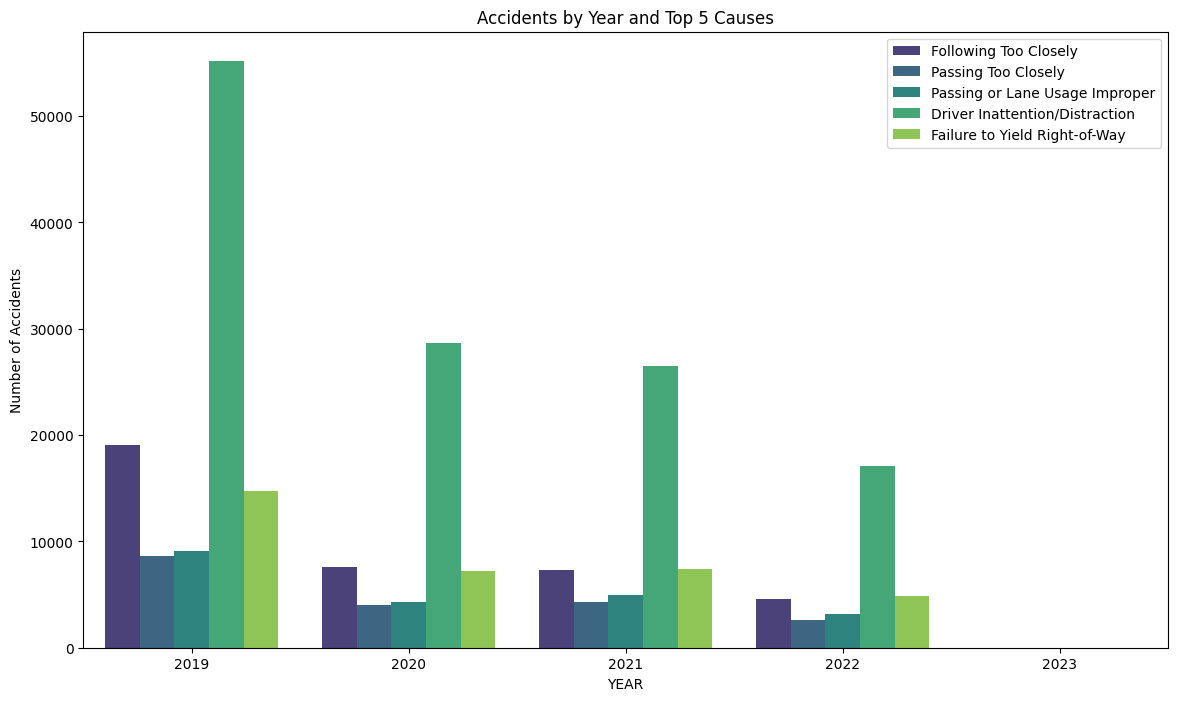

In [ ]:
top_causes = df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().nlargest(5).index
filtered_df = df[df['CONTRIBUTING FACTOR VEHICLE 1'].isin(top_causes)]
plt.figure(figsize=(14, 8))
sns.countplot(data=filtered_df, x='YEAR', hue='CONTRIBUTING FACTOR VEHICLE 1', palette="viridis")
plt.title('Accidents by Year and Top 5 Causes')
plt.ylabel('Number of Accidents')
plt.legend(loc='upper right')
plt.show()


In [ ]:
causation_mapping_df = pd.read_csv('/content/causation_factor_mapping_file.csv')


In [ ]:
# Im "renaming" the columns their original name because my code wasn't registering their name.
causation_mapping_df.columns = ["Causation Factor", "Category"]

df = df.merge(causation_mapping_df, how='left', left_on='CONTRIBUTING FACTOR VEHICLE 1', right_on='Causation Factor')

# If the cause isn't in the mapping, labeling it as 'Unknown'
df['Category'] = df['Category'].fillna('Unknown')

# For redundant columns
df.drop(columns=['Causation Factor'], inplace=True)


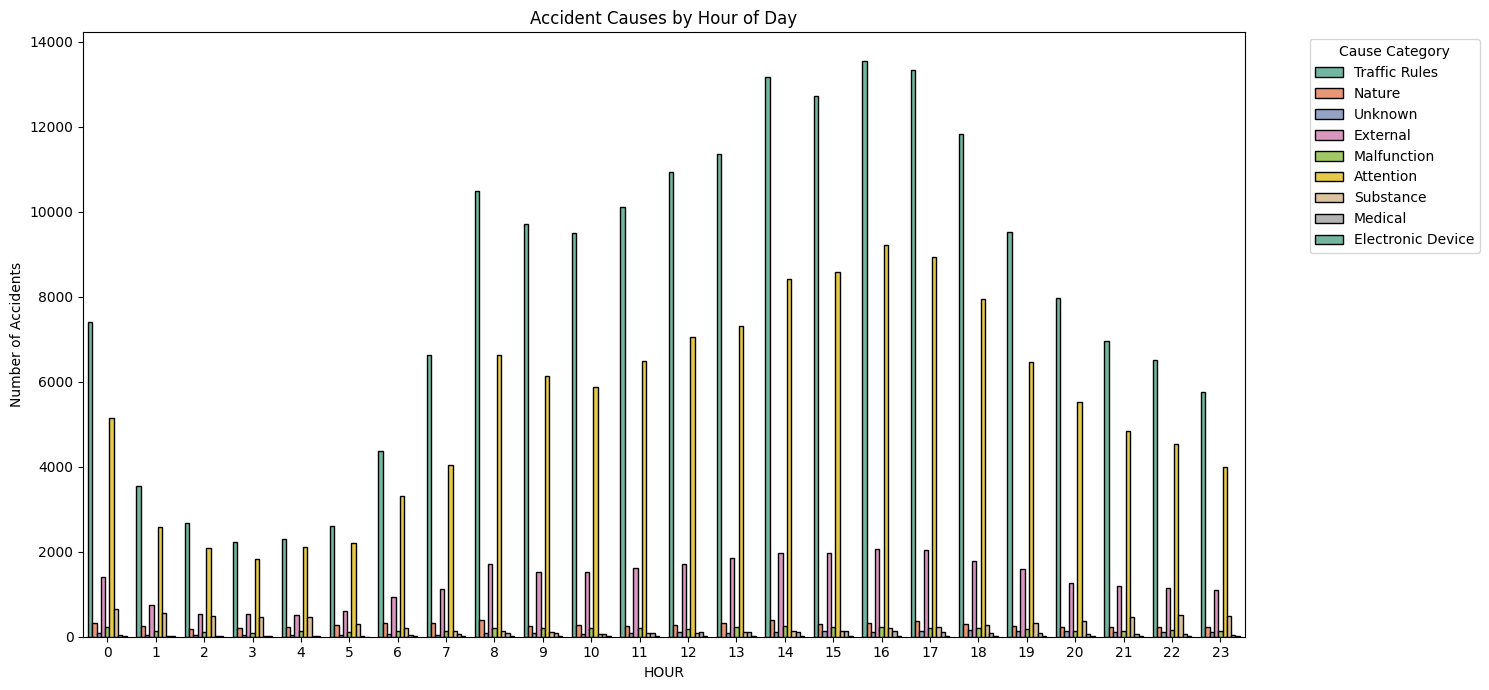

In [ ]:
plt.figure(figsize=(15,7))
sns.countplot(data=df, x='HOUR', hue='Category', palette="Set2", edgecolor='black')
plt.title('Accident Causes by Hour of Day')
plt.ylabel('Number of Accidents')
plt.legend(title='Cause Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


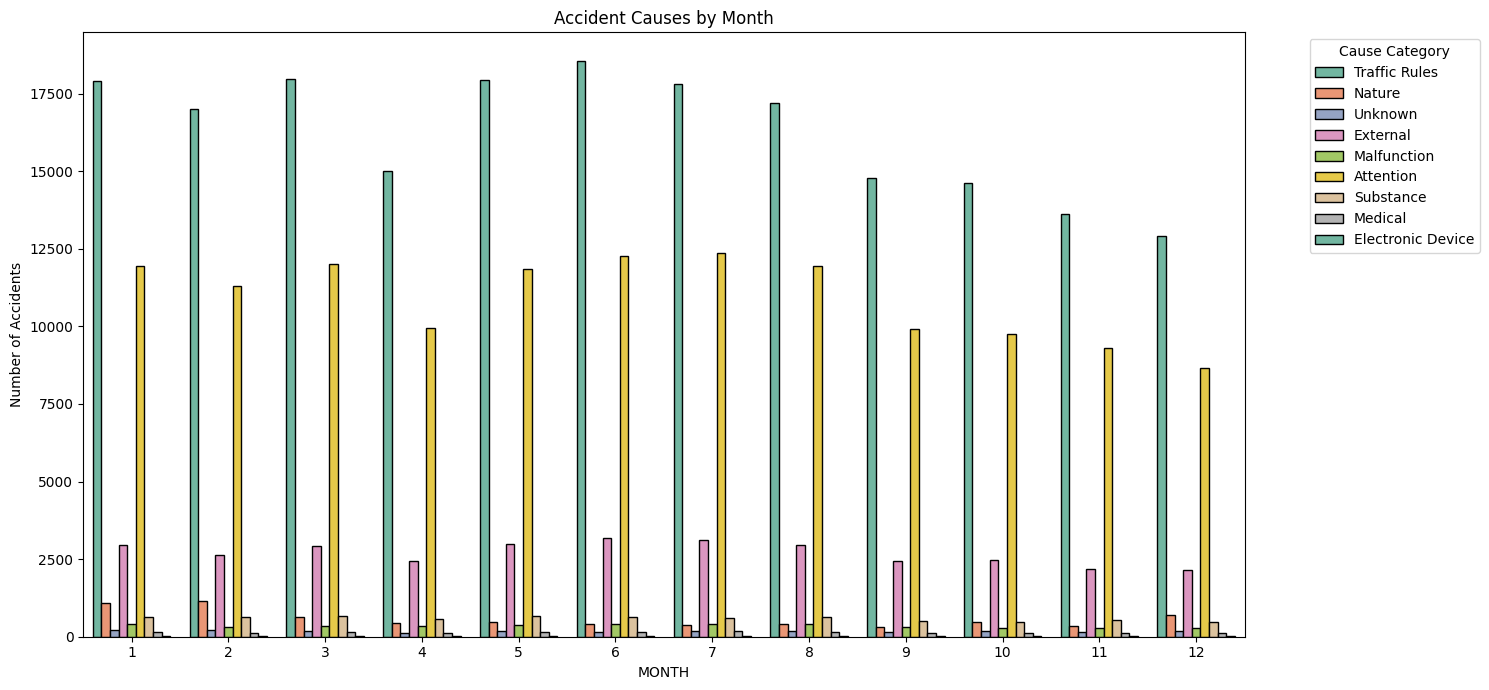

In [ ]:
plt.figure(figsize=(15,7))
sns.countplot(data=df, x='MONTH', hue='Category', palette="Set2", edgecolor='black')
plt.title('Accident Causes by Month')
plt.ylabel('Number of Accidents')
plt.legend(title='Cause Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Top 3 causes by hour and by month

In [ ]:
# Identify top 3 causes across the whole dataset
top_3_causes = df['Category'].value_counts().index[:3]


By hour

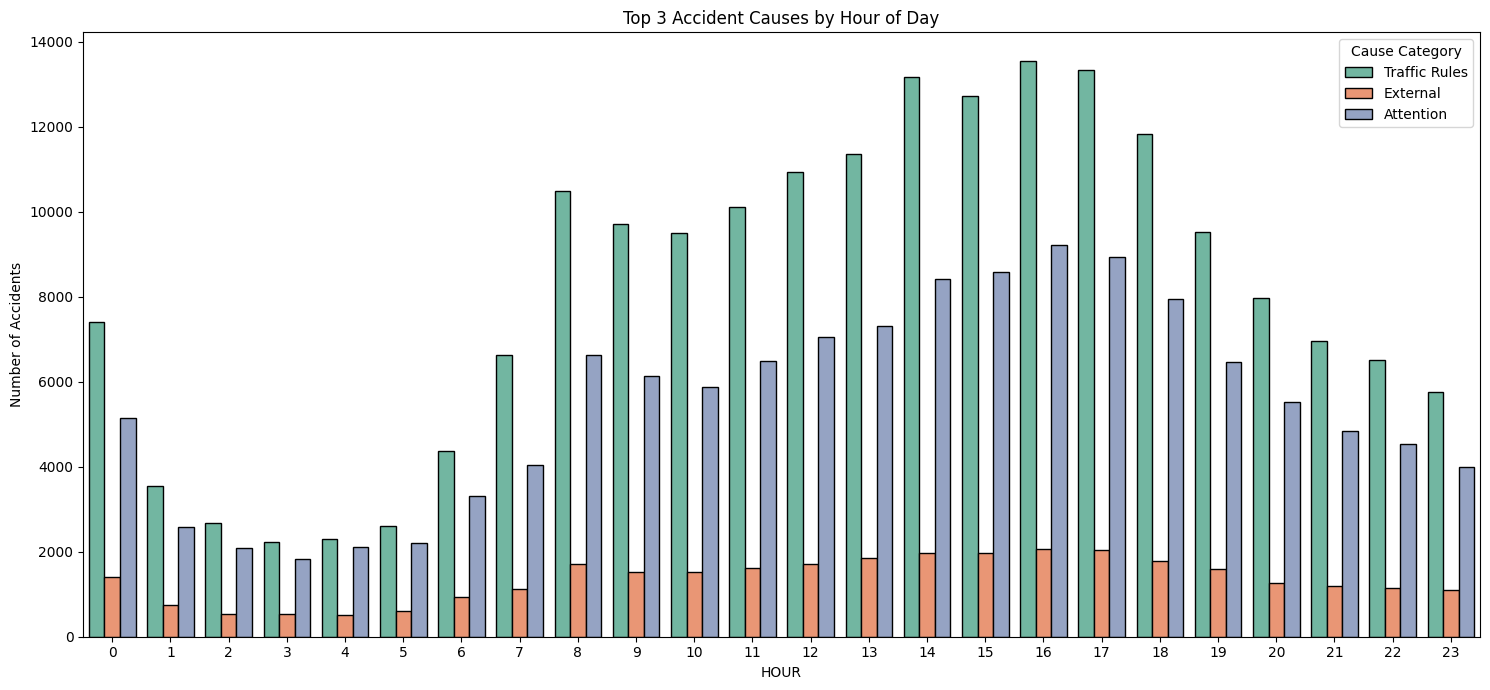

In [ ]:
filtered_df_hour = df[df['Category'].isin(top_3_causes)]

plt.figure(figsize=(15,7))
sns.countplot(data=filtered_df_hour, x='HOUR', hue='Category', palette="Set2", edgecolor='black')
plt.title('Top 3 Accident Causes by Hour of Day')
plt.ylabel('Number of Accidents')
plt.legend(title='Cause Category')
plt.tight_layout()
plt.show()


By month

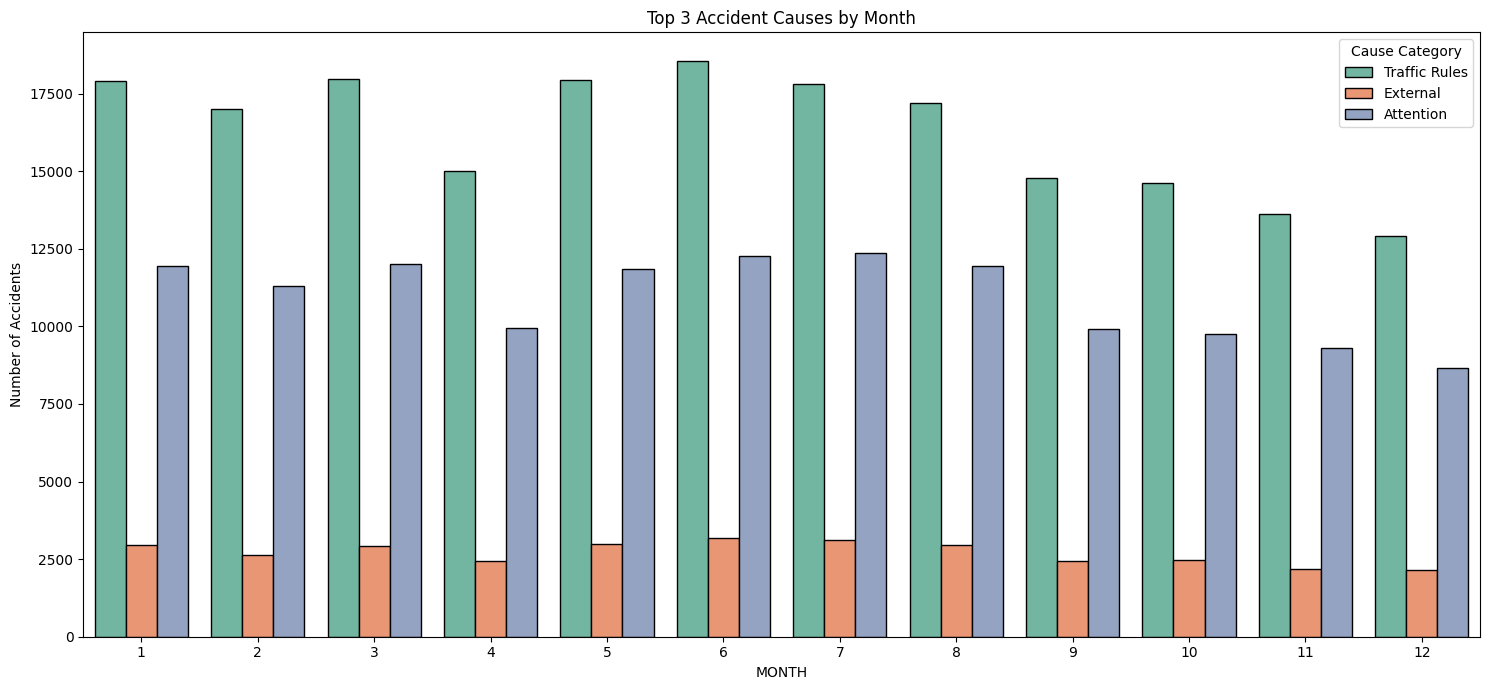

In [ ]:
filtered_df_month = df[df['Category'].isin(top_3_causes)]

plt.figure(figsize=(15,7))
sns.countplot(data=filtered_df_month, x='MONTH', hue='Category', palette="Set2", edgecolor='black')
plt.title('Top 3 Accident Causes by Month')
plt.ylabel('Number of Accidents')
plt.legend(title='Cause Category')
plt.tight_layout()
plt.show()
